# LOGISTIC REGRESSION | VOTE INTENTION

# Load libraries

In [57]:
import arviz as az
import bambi as bmb
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import matplotlib.patheffects as pe

In [2]:
az.style.use("arviz-darkgrid")
SEED = 7355608

## Load data

In [3]:
data = bmb.load_data('ANES')

In [6]:
(data
.filter(['vote'])
.value_counts())

vote        
clinton         215
trump           158
someone_else     48
dtype: int64

In [7]:
(data
.filter(['party_id'])
.value_counts())

party_id   
democrat       186
independent    138
republican      97
dtype: int64

In [10]:
pd.crosstab(index=data['party_id'], columns=data['vote'])

vote         clinton  someone_else  trump
party_id                                 
democrat         159            10     17
independent       51            22     65
republican         5            16     76

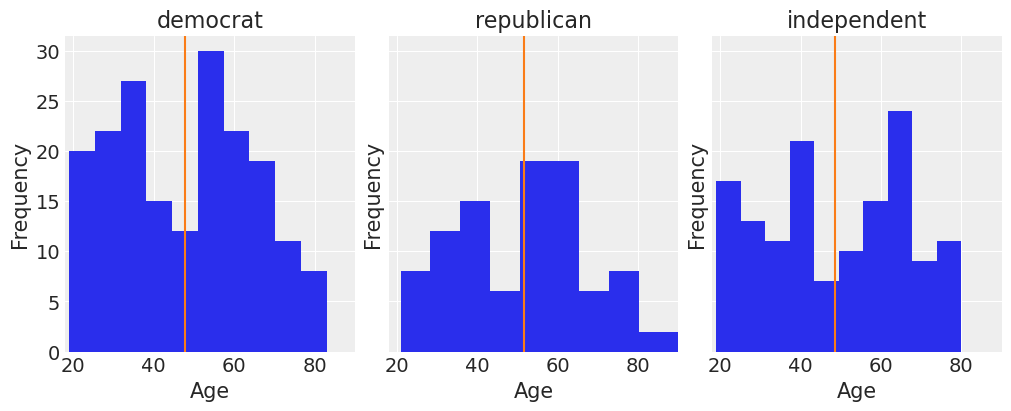

In [11]:
fig, ax = plt.subplots(1, 3, figsize=(10, 4), sharey=True, constrained_layout=True)
key = dict(zip(data["party_id"].unique(), range(3)))
for label, df in data.groupby("party_id"):
    ax[key[label]].hist(df["age"])
    ax[key[label]].set_xlim([18, 90])
    ax[key[label]].set_xlabel("Age")
    ax[key[label]].set_ylabel("Frequency")
    ax[key[label]].set_title(label)
    ax[key[label]].axvline(df["age"].mean(), color="C1")

# Clinton model


In [36]:
# Filter only Clinton and Trump data
cleanData = (data
             .query("vote in ('clinton', 'trump')")
)

In [37]:
(cleanData
.filter(['vote'])
.value_counts())

vote   
clinton    215
trump      158
dtype: int64

In [38]:
clintonMdl = bmb.Model(
                        "vote['clinton'] ~ party_id + party_id:age",
                        cleanData,
                        family = 'bernoulli'
)

In [39]:
clintonMdl

       Formula: vote['clinton'] ~ party_id + party_id:age
        Family: bernoulli
          Link: p = logit
  Observations: 373
        Priors: 
    target = p
        Common-level effects
            Intercept ~ Normal(mu: 0.0, sigma: 4.3846)
            party_id ~ Normal(mu: [0. 0.], sigma: [5.4007 6.0634])
            party_id:age ~ Normal(mu: [0. 0. 0.], sigma: [0.0938 0.1007 0.1098])

In [40]:
clintonMdl.build()

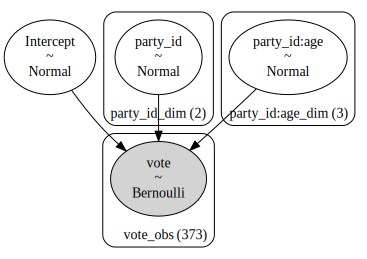

In [41]:
clintonMdl.graph()

Sampling: [Intercept, party_id, party_id:age]


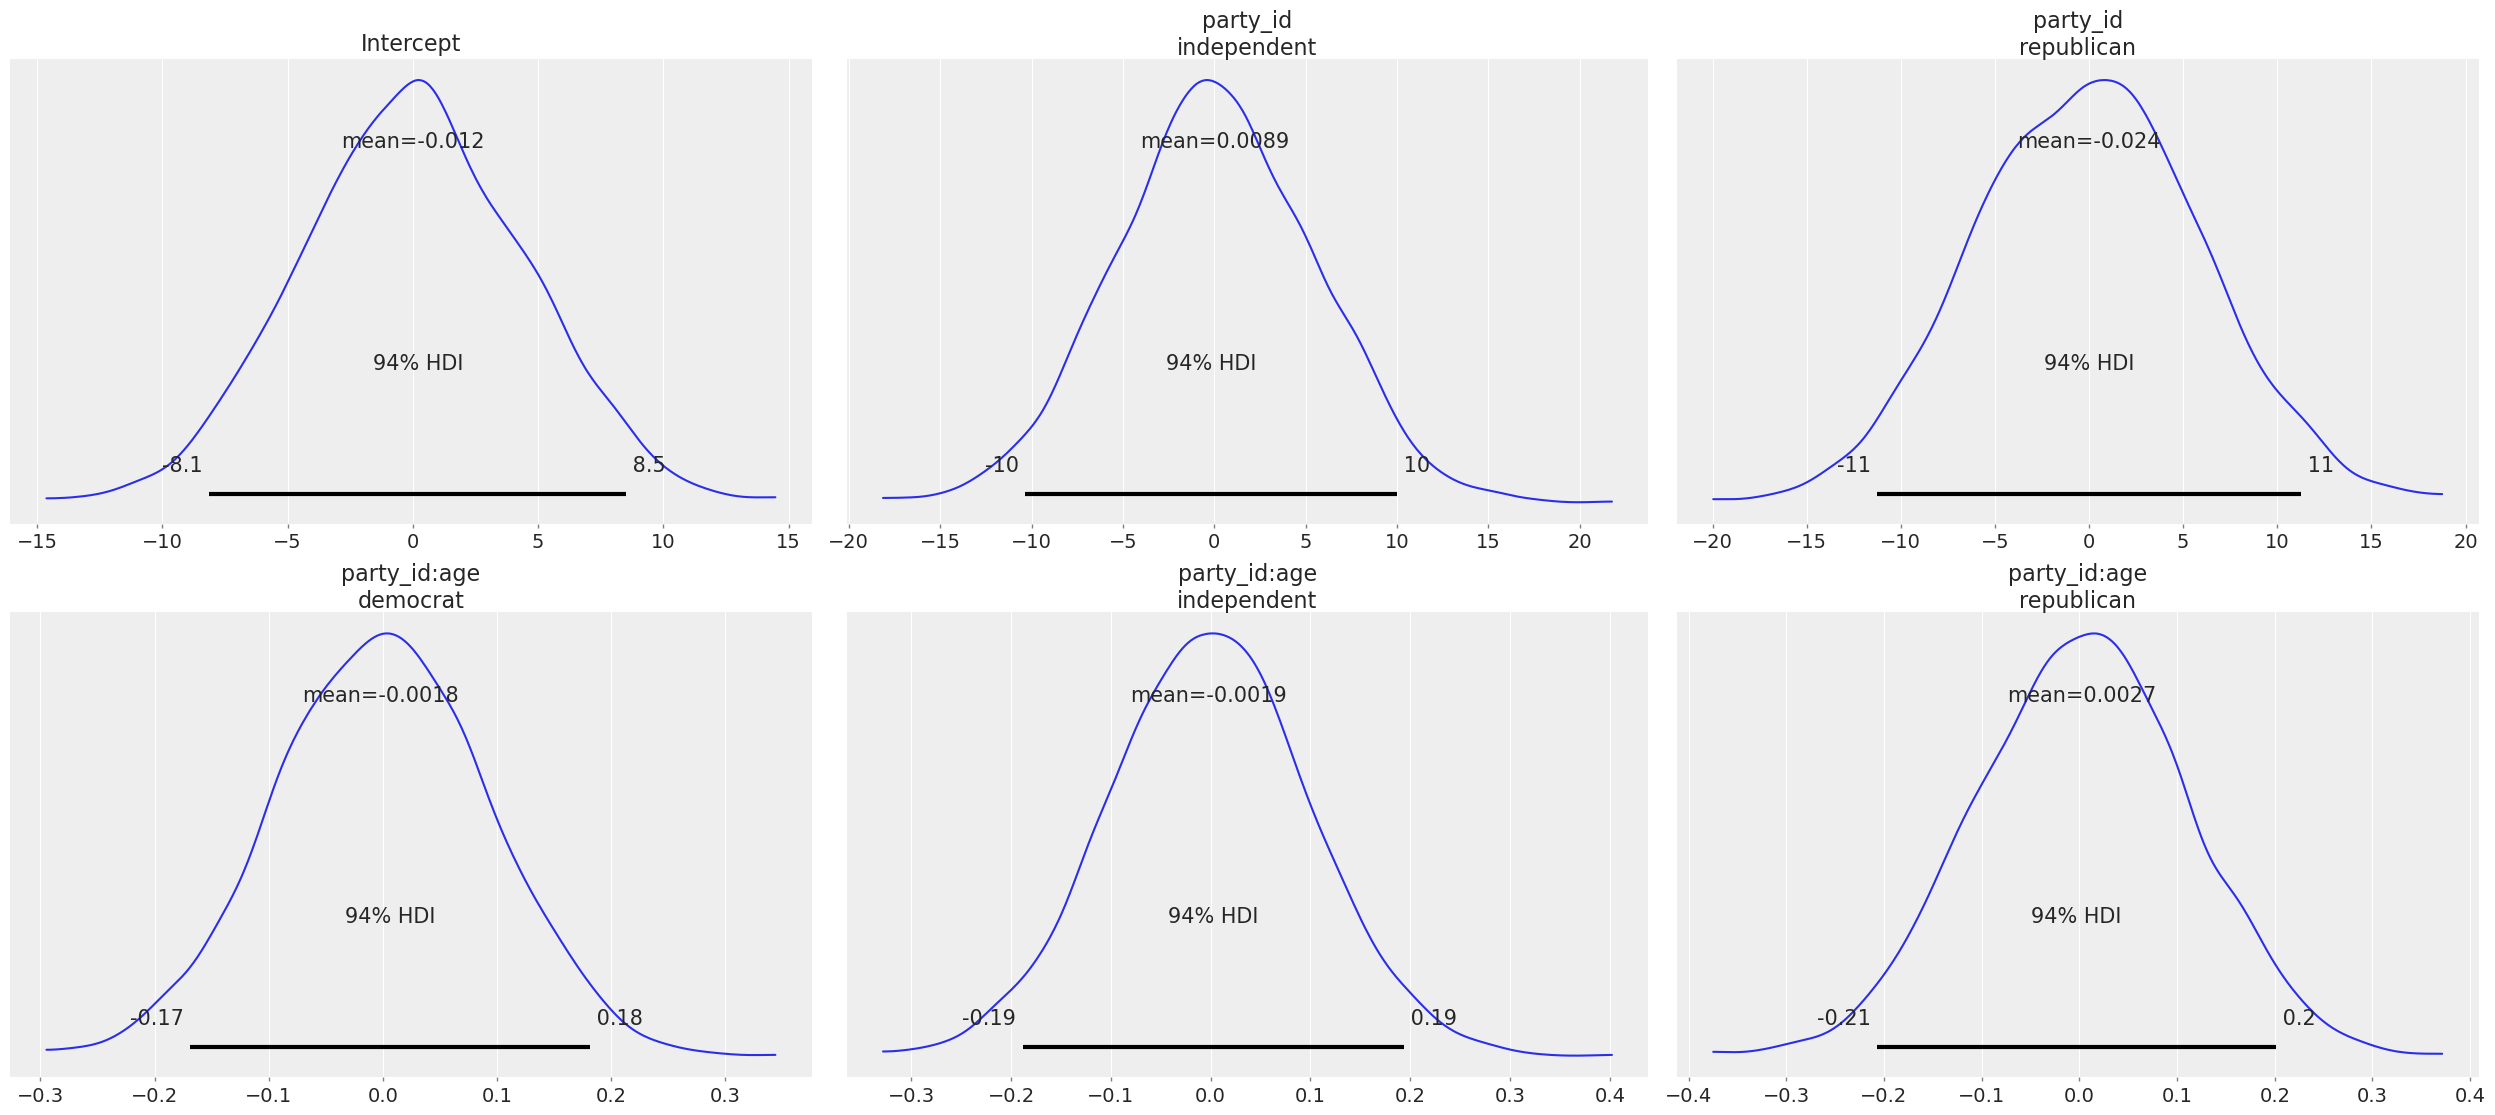

In [42]:
clintonMdl.plot_priors();

In [43]:
clintonFit = clintonMdl.fit(
                            draws = 2000,
                            target_accept = 0.85,
                            random_seed = SEED,
                            idata_kwargs={'log_likelihood': True}
)

Modeling the probability that vote==clinton
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [Intercept, party_id, party_id:age]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 45 seconds.


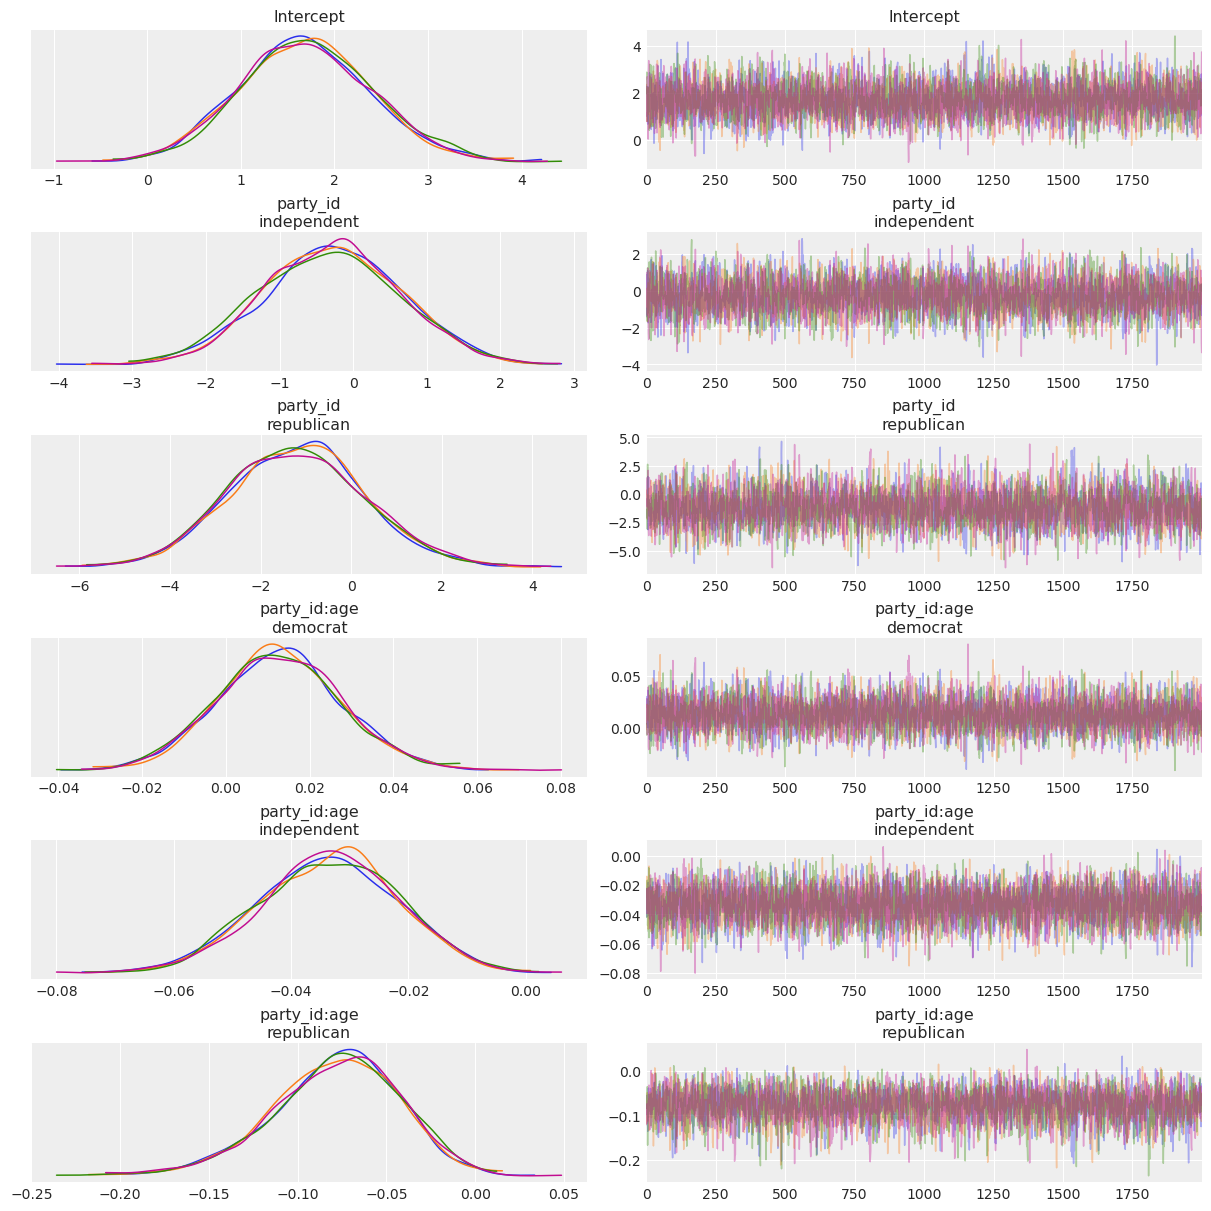

In [44]:
az.plot_trace(clintonFit, compact=False);

## Model assessment

### Separation plot

In [45]:
clintonMdl.predict(clintonFit, kind = 'pps')

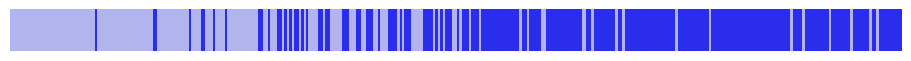

In [46]:
ax = az.plot_separation(clintonFit, y = 'vote', figsize=(9, 0.5))

### K parameter

In [47]:
# Influential observations

loo = az.loo(clintonFit, pointwise = True)

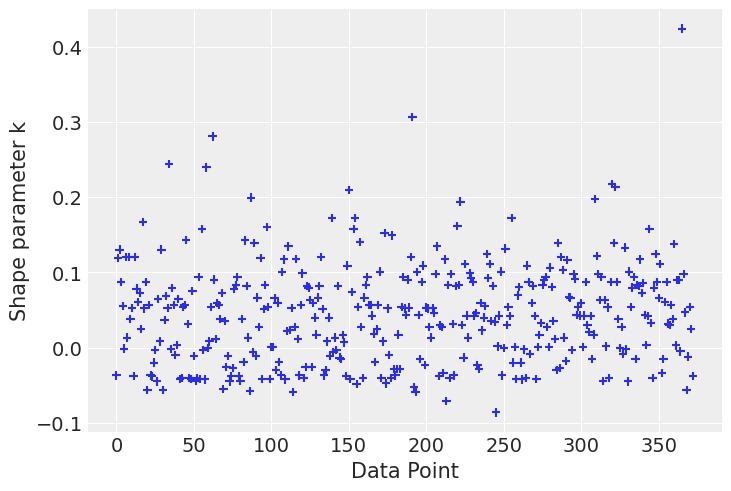

In [48]:
az.plot_khat(loo.pareto_k);

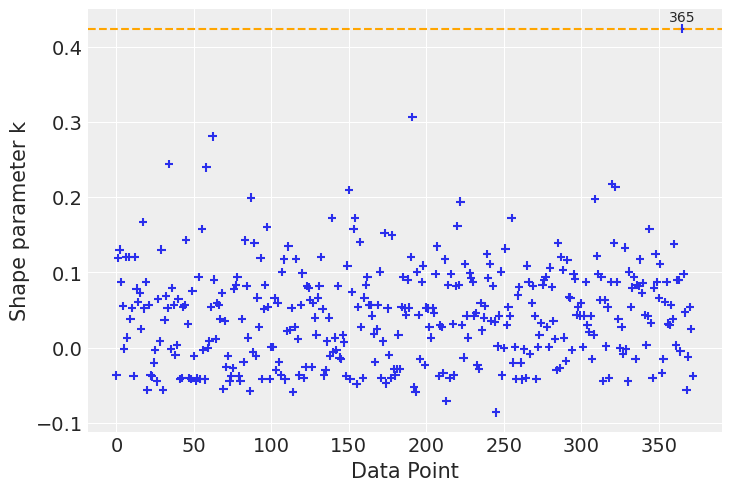

In [50]:
ax = az.plot_khat(loo.pareto_k.values.ravel())
sorted_kappas = np.sort(loo.pareto_k.values.ravel())

# find observation where the kappa value exceeds the threshold
threshold = sorted_kappas[-1:]
ax.axhline(threshold, ls="--", color="orange")
influential_observations = cleanData.reset_index()[loo.pareto_k.values >= threshold].index

for x in influential_observations:
    y = loo.pareto_k.values[x]
    ax.text(x, y + 0.01, str(x), ha="center", va="baseline")

In [51]:
cleanData.reset_index()[loo.pareto_k.values >= threshold]

index     vote  age    party_id
365    410  clinton   55  republican

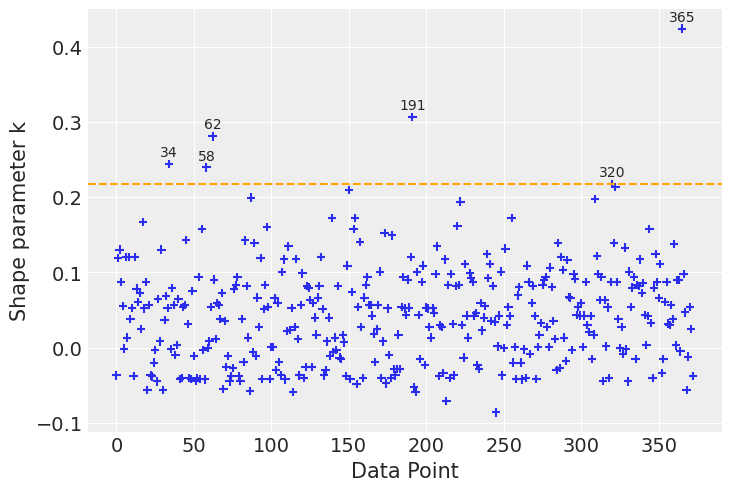

In [55]:
ax = az.plot_khat(loo.pareto_k)

# find observation where the kappa value exceeds the threshold
threshold = sorted_kappas[-6:].min()
ax.axhline(threshold, ls="--", color="orange")
influential_observations = cleanData.reset_index()[loo.pareto_k.values >= threshold].index

for x in influential_observations:
    y = loo.pareto_k.values[x]
    ax.text(x, y + 0.01, str(x), ha="center", va="baseline")

In [56]:
cleanData.reset_index()[loo.pareto_k.values >= threshold]

index     vote  age    party_id
34      34    trump   83  republican
58      64    trump   84  republican
62      68    trump   91  republican
191    215    trump   95  republican
320    359  clinton   22  republican
365    410  clinton   55  republican

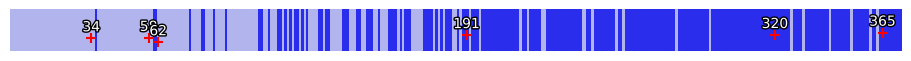

In [60]:
ax = az.plot_separation(clintonFit, y="vote", figsize=(9, 0.5))

y = np.random.uniform(0.1, 0.5, size=len(influential_observations))

for x, y in zip(influential_observations, y):
    text = str(x)
    x = x / len(cleanData)
    ax.scatter(x, y, marker="+", s=50, color="red", zorder=3)
    ax.text(
        x, y + 0.1, text, color="white", ha="center", va="bottom",
        path_effects=[pe.withStroke(linewidth=2, foreground="black")]
    )

In [62]:
cleanData.reset_index()[loo.pareto_k.values>=threshold]

index     vote  age    party_id
34      34    trump   83  republican
58      64    trump   84  republican
62      68    trump   91  republican
191    215    trump   95  republican
320    359  clinton   22  republican
365    410  clinton   55  republican

## Run inference

In [64]:
parties = ["democrat", "independent", "republican"]

dem, ind, rep = [clintonFit.posterior["party_id:age"].sel({"party_id:age_dim":party}) for party in parties]

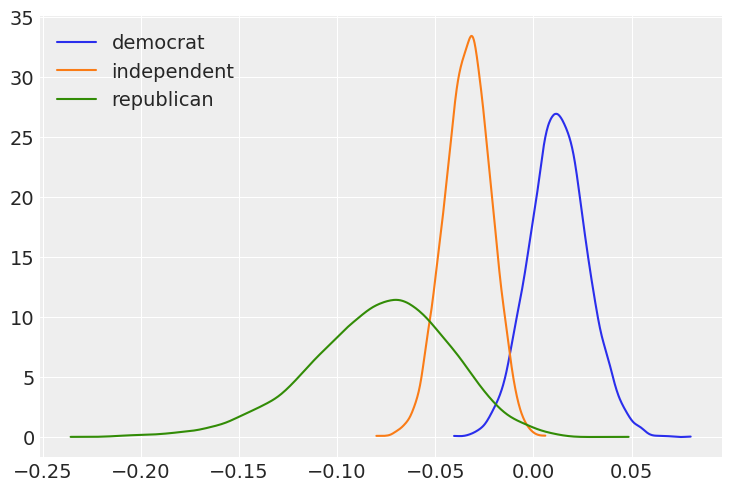

In [65]:
_, ax = plt.subplots()
for idx, x in enumerate([dem, ind, rep]):
    az.plot_dist(x, label=x["party_id:age_dim"].item(), plot_kwargs={"color": f"C{idx}"}, ax=ax)
ax.legend(loc="upper left");

In [66]:
(dem > rep).mean().item()

0.9965

In [67]:
(dem > ind).mean().item()

0.993375

## Spaghetti plot of model predictions

In [69]:
age = np.arange(18, 91)

new_data = pd.DataFrame({
    "age": np.tile(age, 3),
    "party_id": np.repeat(["democrat", "republican", "independent"], len(age))
})

new_data

age     party_id
0     18     democrat
1     19     democrat
2     20     democrat
3     21     democrat
4     22     democrat
..   ...          ...
214   86  independent
215   87  independent
216   88  independent
217   89  independent
218   90  independent

[219 rows x 2 columns]

In [70]:
clintonMdl.predict(clintonFit, data = new_data)

In [73]:
vote_posterior = az.extract(clintonFit, num_samples=2000)["vote_mean"]

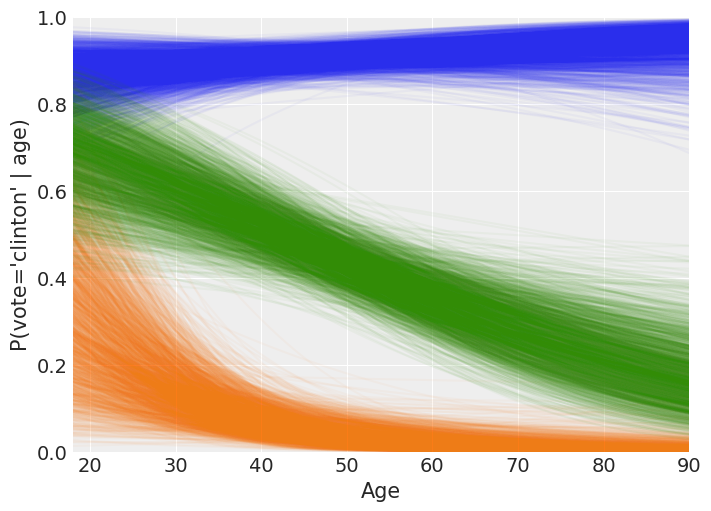

In [74]:
_, ax = plt.subplots(figsize=(7, 5))

for i, party in enumerate(["democrat", "republican", "independent"]):
    # Which rows in new_data correspond to party?
    idx = new_data.index[new_data["party_id"] == party].tolist()
    ax.plot(age, vote_posterior[idx], alpha=0.04, color=f"C{i}")

ax.set_ylabel("P(vote='clinton' | age)")
ax.set_xlabel("Age", fontsize=15)
ax.set_ylim(0, 1)
ax.set_xlim(18, 90);